# Determining size of Pledge 1% network

Through organizations, investments, and jobs, this is the first look at how the growth of individuals changes over time in comparison with the Crunchbase data. We create some initial definitions for who is counted as someone "in the network."

In [1]:
# User defined functions
import base_methods
from base_methods import load_the_csvs, column_formatter

# Import data analysis packages
import pandas as pd
from datetime import datetime, timedelta

# Misc
import warnings
warnings.filterwarnings('ignore')

# Import plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3)
sns.set_style("white")

### Loading data

Data sourced from the <a href='https://www.crunchbase.com/'>Crunchbase API</a> via Pledge 1%'s Enterprise License Agreement.

In [2]:
# Store path to notebook
PWD = !pwd
PWD = PWD[0]

# Set global paths to data folders
!mkdir {PWD}/files/output/
print()
INPUT = PWD + '/files/csv/'
OUTPUT = PWD + '/files/output/'

# Load
df,p1_inv,p1_part,p1_jobs = load_the_csvs(loc=OUTPUT,
                                          data=['organizations_merged','p1_investments',
                                                'p1_investments_partner','p1_jobs'],
                                          verbose=True)

df = column_formatter(df)
p1_inv = column_formatter(p1_inv)
p1_part = column_formatter(p1_part)
p1_jobs = column_formatter(p1_jobs)

mkdir: cannot create directory ‘/home/ski/Desktop/crunchbase-p1-machine-learning/files/output/’: File exists

/HOME/SKI/DESKTOP/CRUNCHBASE-P1-MACHINE-LEARNING/FILES/OUTPUT/ORGANIZATIONS_MERGED.CSV
ORGANIZATIONS_MERGED shape: (1131315, 16)
ORGANIZATIONS_MERGED columns: ['uuid', 'name', 'type', 'rank', 'roles', 'country_code', 'region', 'status', 'category_groups_list', 'total_funding_usd', 'founded_on', 'closed_on', 'employee_count', 'primary_role', 'p1_tag', 'p1_date']

/HOME/SKI/DESKTOP/CRUNCHBASE-P1-MACHINE-LEARNING/FILES/OUTPUT/P1_INVESTMENTS.CSV
P1_INVESTMENTS shape: (517639, 17)
P1_INVESTMENTS columns: ['investment_uuid', 'funding_round_uuid', 'investor_uuid', 'investor_name', 'investor_type', 'is_lead_investor', 'lead_investor_uuids', 'org_uuid', 'investment_type', 'announced_on', 'raised_amount_usd', 'post_money_valuation_usd', 'investor_count', 'lead_investor_count', 'org_name', 'p1_tag', 'p1_date']

/HOME/SKI/DESKTOP/CRUNCHBASE-P1-MACHINE-LEARNING/FILES/OUTPUT/P1_INVESTMENTS_P

### Print out comparisons between size of Crunchbase and Pledge 1% networks

In [3]:
def size_of_network(df, inv, part, jobs, array_of_date_strings):
    data = {'cb':{date:['cb'] for date in array_of_date_strings}, 
            'p1':{date:['p1'] for date in array_of_date_strings}}
    
    for org_type in data.keys():
        for date in data[org_type].keys():
            all_org = df[(df['founded_on']<=date)&((df['closed_on']>=date)|(pd.isnull(df['closed_on'])))][['uuid','primary_role','p1_date','p1_tag']]
            all_inv = inv[(inv['announced_on']<=date)&(inv['investor_type']=='organization')][['investment_uuid','investor_uuid','p1_date','p1_tag']]
            all_part = part[part['announced_on']<=date][['investment_uuid','partner_uuid','p1_date','p1_tag']]
            all_jobs = jobs[(jobs['started_on']<=date)&((jobs['ended_on']>=date)|(pd.isnull(jobs['ended_on'])))][['job_type','person_uuid','p1_date','p1_tag']]
           
            if org_type=='cb':
                # Organizations - Companies
                cb_org = all_org['uuid'][all_org['primary_role']=='company'].unique()
                # Organizations - Investors
                cb_inr = all_org['uuid'][all_org['primary_role']=='investor'].unique()
                # Organizations - Investors of Organizations
                cb_org_inr = all_inv['investor_uuid'].unique()
                
                # Investments
                cb_inv = all_inv['investment_uuid'].unique()
                # Partner Investments
                cb_part_inv = all_part['investment_uuid'].unique()
                
                # Partners - Investors of Organizations
                cb_part_inr = all_part['partner_uuid'].unique()
                # Jobs
                cb_exec = all_jobs['person_uuid'][all_jobs['job_type']=='executive'].unique()        
                cb_board = all_jobs['person_uuid'][all_jobs['job_type']=='board_member'].unique()       
                cb_adv = all_jobs['person_uuid'][all_jobs['job_type'].isin(['advisor','board_observer'])].unique() 
        
                list_of_list = [cb_org,cb_inr,cb_org_inr,cb_inv,cb_part_inv,cb_part_inr,cb_exec,cb_board,cb_adv]
                
            if org_type=='p1':
                # Organizations - Companies
                p1_org = all_org['uuid'][(all_org['primary_role']=='company')&(all_org['p1_date']<=date)].unique()
                # Organizations - Investors
                p1_inr = all_org['uuid'][(all_org['primary_role']=='investor')&(all_org['p1_date']<=date)].unique()
                # Organizations - Investors of Organizations
                p1_org_inr = all_inv['investor_uuid'][all_inv['p1_tag']==1].unique()
    
                # Investments
                p1_inv = all_inv['investment_uuid'][all_inv['p1_tag']==1].unique()
                # Partner Investments
                p1_part_inv = all_part['investment_uuid'][all_part['p1_tag']==1].unique()
    
                # Partners - Investors of Organizations
                p1_part_inr = all_part['partner_uuid'][all_part['p1_tag']==1].unique()
                # Jobs
                p1_exec = all_jobs['person_uuid'][(all_jobs['job_type']=='executive')&(all_jobs['p1_tag']==1)&(all_jobs['p1_date']<=date)].unique()
                p1_board = all_jobs['person_uuid'][(all_jobs['job_type']=='board_member')&(all_jobs['p1_tag']==1)&(all_jobs['p1_date']<=date)].unique()
                p1_adv = all_jobs['person_uuid'][(all_jobs['job_type'].isin(['advisor','board_observer']))&(all_jobs['p1_tag']==1)&(all_jobs['p1_date']<=date)].unique()
                
                list_of_list = [p1_org,p1_inr,p1_org_inr,p1_inv,p1_part_inv,p1_part_inr,p1_exec,p1_board,p1_adv]
            
            # Add to dictionary
            for group in list_of_list:
                data[org_type][date].append(len(group))
    
    # Convert to dataframe
    col_names = ['type','org','investor','investor_of_org','investment','investment_partner',
                 'partner_investor','executive','board','advisor']        
    cb = pd.DataFrame.from_dict(data['cb'], orient='index', columns=col_names)
    p1 = pd.DataFrame.from_dict(data['p1'], orient='index', columns=col_names)
    data = pd.concat([cb,p1]).reset_index().rename({'index':'date'},axis=1)
    data['combined_org'] = data['org'] + data['investor']
    data['combined_people'] = data['partner_investor'] + data['executive'] + data['board'] + data['advisor']
    
    return data

### Growth of people network between 2014 and 2020

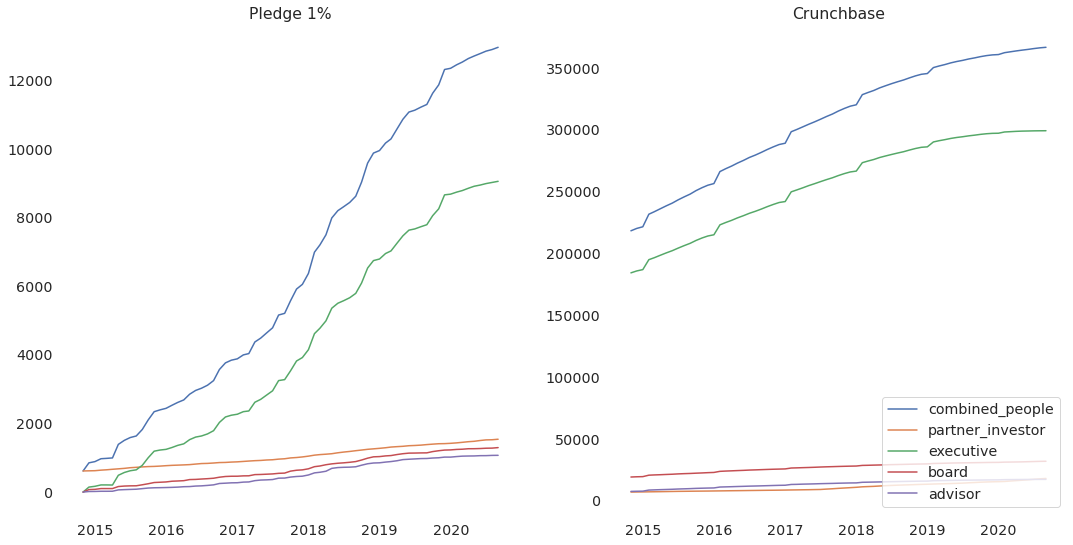

In [4]:
datelist = pd.date_range(start=datetime(2014, 10, 1).date(), end=datetime(2020, 9, 8).date(), freq='M').to_pydatetime().tolist()
data = size_of_network(df, p1_inv, p1_part, p1_jobs, datelist)
titles = {'p1':'Pledge 1%', 'cb':'Crunchbase'}
# Plot the people type subplots
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,9))
people_list = ['combined_people','partner_investor','executive','board','advisor']
for ax, org_type in zip(axes,['p1','cb']):
    for people in people_list:
        sns.lineplot(x='date',y=people,data=data[data['type']==org_type],ax=ax)
    ax.set_title(titles[org_type])
    ax.set_xlabel('')
    ax.set_ylabel('') 
    
# Display
sns.despine(left=True, bottom=True)
plt.legend(title='', loc='lower right', labels=people_list)
plt.show()

What can we see here?
- Executives make up the majority of the people within Crunchbase and grow steadily over time.
- Pledge 1% has a higher percentage of partner investors in their network than Crunchbase.
- The non-employee leadership roles (board, advisor) have flattened growth profiles.